In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from scipy.ndimage.interpolation import shift

df = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = ['Month'])

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


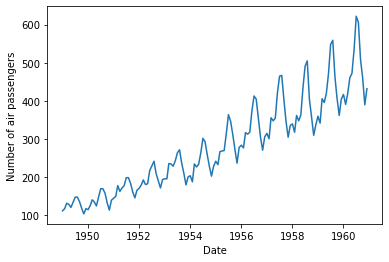

In [2]:
# Print data points

df = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = ['Month'])
print(df.head())
plt.xlabel('Date')  
plt.ylabel('Number of air passengers')
plt.plot(df)
plt.show()

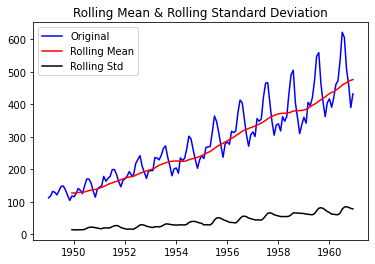

In [3]:
# Check for basic mean and Std dev

rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [4]:
# Adfuller test

result = adfuller(df['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.8153688792060423
p-value: 0.9918802434376409
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


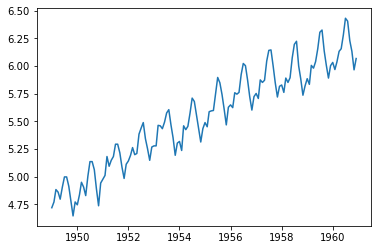

In [5]:
# Since the TS is not stationary, take log. The log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.
df_log = np.log(df)
plt.plot(df_log)
plt.show()
# By taking log, the Y axis gets changed 

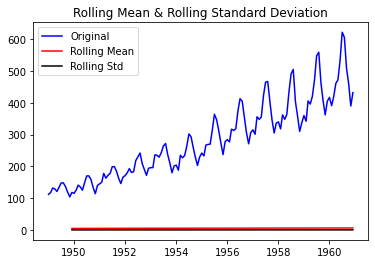

In [7]:
# Check for basic mean and Std dev

rolling_mean = df_log.rolling(window = 12).mean()
rolling_std = df_log.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [8]:
# Adfuller test

result = adfuller(df_log['Passengers'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.7170170891069714
p-value: 0.4223667747703857
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [18]:
# Function to check stationarity 

def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

            Passengers
Month                 
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
...                ...
1960-08-01    0.282363
1960-09-01    0.098235
1960-10-01   -0.009230
1960-11-01   -0.182690
1960-12-01   -0.085789

[133 rows x 1 columns]


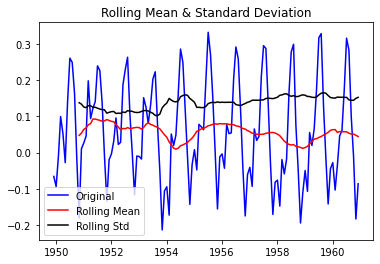

ADF Statistic: -3.162907991300858
p-value: 0.022234630001243844
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


In [19]:

# Removing Trend
# Using MA since the Time stamp is clear 

df_log= np.log(df)
rolling_mean = df_log.rolling(window=12).mean()
# df_log.rolling(window = 12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
print(df_log_minus_mean)
get_stationarity(df_log_minus_mean)


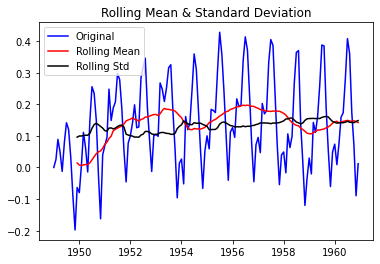

ADF Statistic: -3.601262420161679
p-value: 0.005736938801511851
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [20]:
#Remove trend
#In case of time stamp being complex use EWMA to remove trend eg: Stock data
df_log=np.log(df)
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

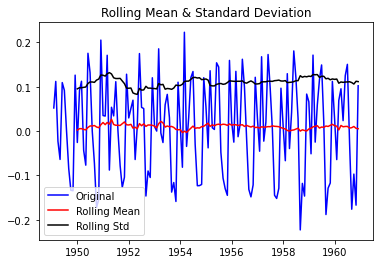

ADF Statistic: -2.717130598388145
p-value: 0.0711205481508568
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


In [152]:
#Remove seasonality 
#By differencing
#Use shift function to shift to any order of differentiation and then subtract it from log 
#In this case shifting it by 1 to perform first order differentiation
df_log_shift=df_log.shift()
df_log_diff= df_log- df_log.shift()
df_log_diff.dropna(inplace=True)
get_stationarity(df_log_diff)




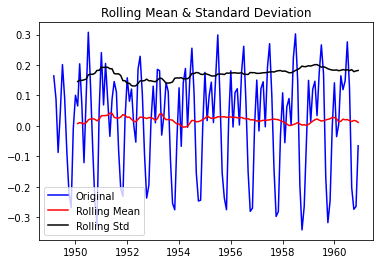

ADF Statistic: -3.1679073752887454
p-value: 0.021919114564038708
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [33]:
#Remove seasonality by differentiating it with order 2
#This can be done depending on the % of confidence we expect. By differentiating to second order we achieve 95% confidence 
#whereas in previous case, we achieved 90% confidence

df_log_shift=df_log.shift(2,axis=0)
df_log_diff= df_log- df_log.shift(2,axis=0)
df_log_diff.dropna(inplace=True)
get_stationarity(df_log_diff)

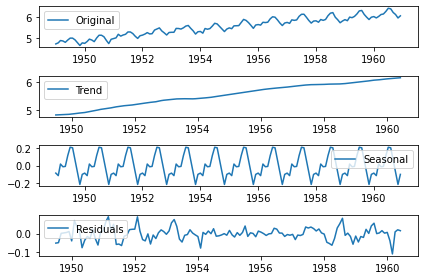

In [39]:
#Another way to remove seasonality and trend is decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(df_log)
trend= decomposition.trend
seasonal= decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [42]:
# Now that we have decomposed the TS, we can check stationarity 
# in residual
df_log_decompose= residual
df_log_decompose.dropna(inplace=True)



C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  # see for example


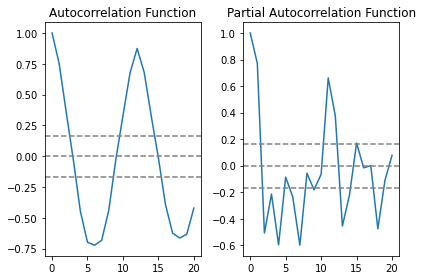

In [58]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [61]:
# The line crosses upper confidence interval is used to determine lag
# PACF, when the line crosses UPL, corresponding lag is p here p--2, corresponds to AR
#ACF, when the line crosses UPL, corrresponding lag is q hence q--2, corresponds to MA


C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  index[key]
C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  index[key]


Text(0.5, 1.0, 'RSS: 1.5023')

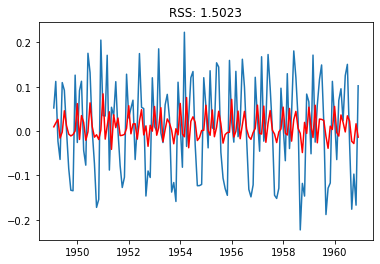

In [154]:
from statsmodels.tsa.arima_model import ARIMA

#AR model
model = ARIMA(df_log, order=(2, 1, 0))  
results_ARIMA= model.fit(disp=-1)
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_log_diff['Passengers'])**2))


C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  index[key]
C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  index[key]


Text(0.5, 1.0, 'RSS: 1.4721')

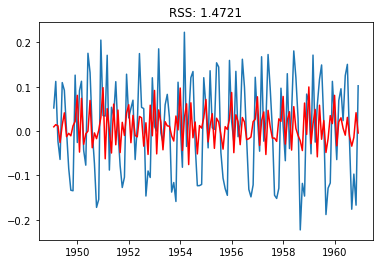

In [155]:
from statsmodels.tsa.arima_model import ARIMA

#MA model
model = ARIMA(df_log, order=(0, 1, 2))  
results_ARIMA= model.fit(disp=-1)
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_log_diff['Passengers'])**2))

C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  index[key]
C:\Users\jeban\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  index[key]


Text(0.5, 1.0, 'RSS: 1.0292')

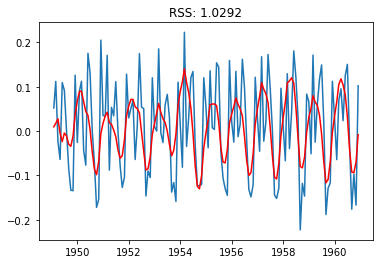

In [156]:
from statsmodels.tsa.arima_model import ARIMA

#ARMA model
model = ARIMA(df_log, order=(2, 1, 2))  
results_ARIMA= model.fit(disp=-1)
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_log_diff['Passengers'])**2))

In [157]:
# Reverse transformation >> to remove the lag 1 while diff

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [159]:
#Convert to cumulative sum to remove differentition
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372552
1960-09-01    1.280202
1960-10-01    1.186189
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64


In [164]:
#To remove Moving average, add log of first value with the cumsum
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

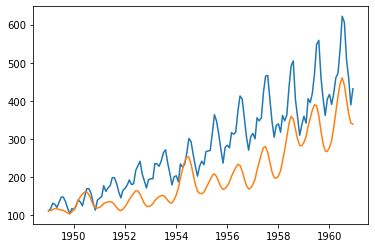

In [166]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

In [167]:
df_log

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


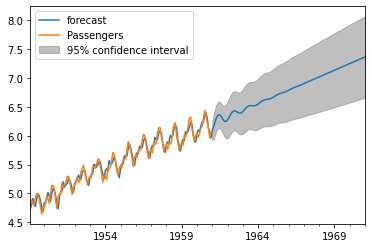

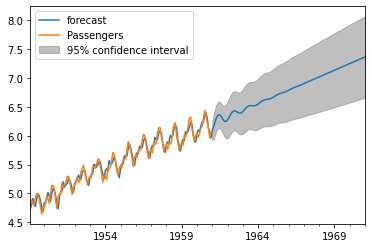

In [170]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 